In [1]:
import os
import sys
maindir = os.getcwd()
sys.path.append(maindir+"/src")

In [2]:
import pickle
import torch
import numpy as np
import matplotlib.pyplot as plt

from preprocessing import data_processing, compute_anomalies_and_scalers, \
                            compute_forced_response, \
                            numpy_to_torch, rescale_and_merge_training_and_test_sets, \
                            rescale_training_and_test_sets,merge_training_and_test_sets


from plot_tools import plot_gt_vs_pred, animation_gt_vs_pred
from leave_one_out import leave_one_out_single, leave_one_out_procedure
from cross_validation import cross_validation_procedure


from algorithms import ridge_regression, ridge_regression_low_rank, \
                        train_trace_norm,train_robust_weights, train_robust_weights_trace_norm,\
                        prediction, compute_weights

In [3]:
############### Load climate model raw data for SST
with open('data/ssp585_time_series.pkl', 'rb') as f:
    data = pickle.load(f)

###################### Load longitude and latitude 
with open('data/lon.npy', 'rb') as f:
    lon = np.load(f)

with open('data/lat.npy', 'rb') as f:
    lat = np.load(f)

# define grid (+ croping for latitude > 60)
lat_grid, lon_grid = np.meshgrid(lat[lat<=60], lon, indexing='ij')

lat_size = lat_grid.shape[0]
lon_size = lon_grid.shape[1]

In [54]:
# define pytorch precision
dtype = torch.float32

data_processed, notnan_idx, nan_idx = data_processing(data, lon, lat,max_models=100)
x, means, vars = compute_anomalies_and_scalers(data_processed, lon_size, lat_size, nan_idx, time_period=34)
y = compute_forced_response(data_processed, lon_size, lat_size, nan_idx, time_period=34)

x,y, means, vars = numpy_to_torch(x,y,means,vars, dtype=dtype)

############### REMOVE model 'GISS-E2-2-G' from the dataset ################
x.pop('GISS-E2-2-G')
y.pop('GISS-E2-2-G')
means.pop('GISS-E2-2-G')
vars.pop('GISS-E2-2-G')

/home/vcohen/cope/src/preprocessing.py:90: RuntimeWarning: Mean of empty slice
  means[m] = np.nanmean(data_reshaped[m],axis=(0,1))
/home/vcohen/cope/src/preprocessing.py:94: RuntimeWarning: Degrees of freedom <= 0 for slice.
  vars[m] = np.nanvar(data_reshaped[m],axis=(0,1))
/home/vcohen/cope/src/preprocessing.py:129: RuntimeWarning: Mean of empty slice
  mean_spatial_ensemble = np.nanmean(y_tmp,axis=0)


tensor([   nan,    nan,    nan,  ..., 0.1041, 0.1140,    nan])

In [57]:
# m0= 'ICON-ESM-LR'
# m0 ='GISS-E2-2-G'
# m0 = 'EC-Earth3'
m0 = 'GISS-E2-2-H'
training_models, x_rescaled, y_rescaled = rescale_training_and_test_sets(m0,x,y,means,vars,dtype=dtype)
training_models, x_train, y_train, x_test, y_test = rescale_and_merge_training_and_test_sets(m0,x,y,means,vars,dtype=dtype)

# training_models, x_train, y_train, x_test, y_test =  merge_training_and_test_sets(m0,x,y,means,vars,dtype=dtype)

In [ ]:
lambda_tmp = 500.0
mu_tmp = 1000.0
nu_tmp = 500.0

# compute ridge regressor
w_ridge = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
w_ridge[np.ix_(notnan_idx,notnan_idx)] = ridge_regression(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=lambda_tmp, dtype=dtype)

# compute low rank ridge regressor
r = 5
w_ridge_lr = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
w_ridge_lr[np.ix_(notnan_idx,notnan_idx)] = ridge_regression_low_rank(x_train[:,notnan_idx], y_train[:,notnan_idx], rank=r, lambda_=lambda_tmp, dtype=dtype)

# compute trace norm regressor
w_trace = torch.zeros(lon_size*lat_size,lon_size*lat_size,dtype=dtype)
w_trace[np.ix_(notnan_idx,notnan_idx)]  = train_trace_norm(x_train[:,notnan_idx], y_train[:,notnan_idx], lambda_=lambda_tmp, nu_=nu_tmp, dtype=dtype,verbose=True)
print("Rank of the matrix: ", torch.linalg.matrix_rank(w_trace[np.ix_(notnan_idx,notnan_idx)]).item())

# # compute robust weight trace norm
w_robust_trace = train_robust_weights_trace_norm(training_models,x_rescaled,y_rescaled,lon_size,lat_size,notnan_idx,\
                                                 lambda_= lambda_tmp,mu_=mu_tmp,nu_=nu_tmp,\
                                                 lr=1e-6,nb_iterations=50,dtype=dtype, verbose=True)

# # compute robust ridge regressor
w_robust  = train_robust_weights(training_models,x_rescaled,y_rescaled,lon_size,lat_size,notnan_idx,\
                                rank=None,lambda_= lambda_tmp,mu_=mu_tmp,\
                                lr=1e-6,nb_iterations=50,dtype=dtype, verbose=True)

# # compute robust ridge regressor low rank (low-rank constraints)
w_robust_lr  = train_robust_weights(training_models,x_rescaled,y_rescaled,lon_size,lat_size,notnan_idx,\
                                    rank=r,lambda_= lambda_tmp,mu_=mu_tmp,\
                                    lr=1e-6,nb_iterations=50,dtype=dtype, verbose=True)

Loss function:  1735772.5
Rank of the matrix:  11
Iteration  0 : Loss function :  18860.6640625
Rank of w:  tensor(8)
Iteration  1 : Loss function :  18525.1640625
Rank of w:  tensor(8)
Iteration  2 : Loss function :  18128.18359375
Rank of w:  tensor(8)
Iteration  3 : Loss function :  17712.091796875
Rank of w:  tensor(8)
Iteration  4 : Loss function :  17297.701171875
Rank of w:  tensor(8)
Iteration  5 : Loss function :  16895.921875
Rank of w:  tensor(8)
Iteration  6 : Loss function :  16512.498046875
Rank of w:  tensor(8)
Iteration  7 : Loss function :  16150.2861328125
Rank of w:  tensor(8)
Iteration  8 : Loss function :  15810.4404296875
Rank of w:  tensor(8)
Iteration  9 : Loss function :  15493.064453125
Rank of w:  tensor(8)
Iteration  10 : Loss function :  15197.6533203125
Rank of w:  tensor(8)
Iteration  11 : Loss function :  14923.3583984375
Rank of w:  tensor(8)
Iteration  12 : Loss function :  14669.0810546875
Rank of w:  tensor(8)
Iteration  13 : Loss function :  14433.6

/tmp/ipykernel_24393/525129004.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(training_models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


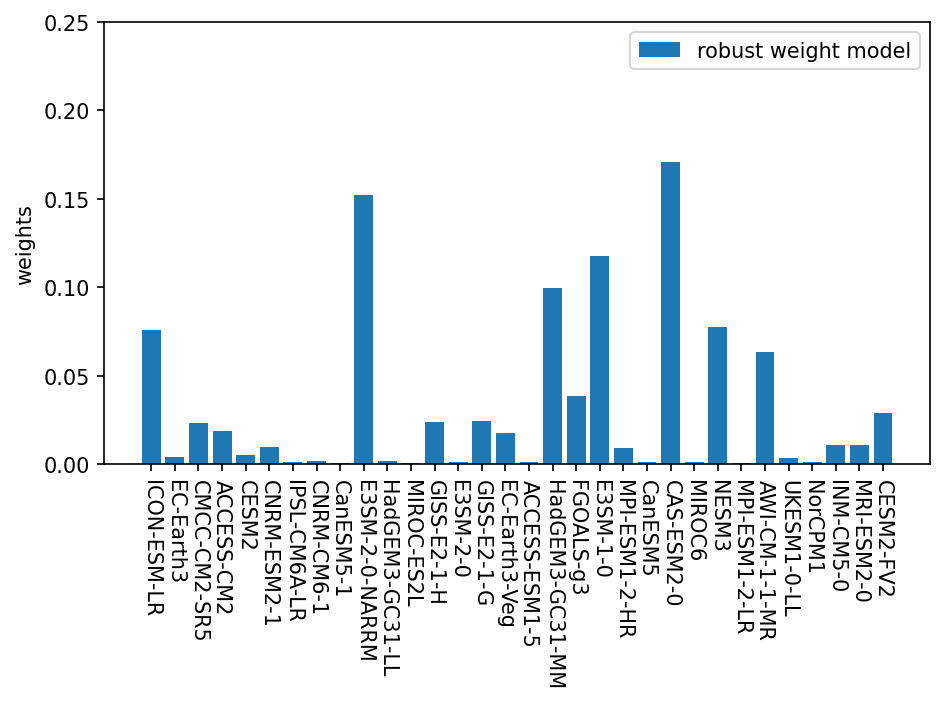

/tmp/ipykernel_24393/525129004.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(training_models, rotation=-90)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


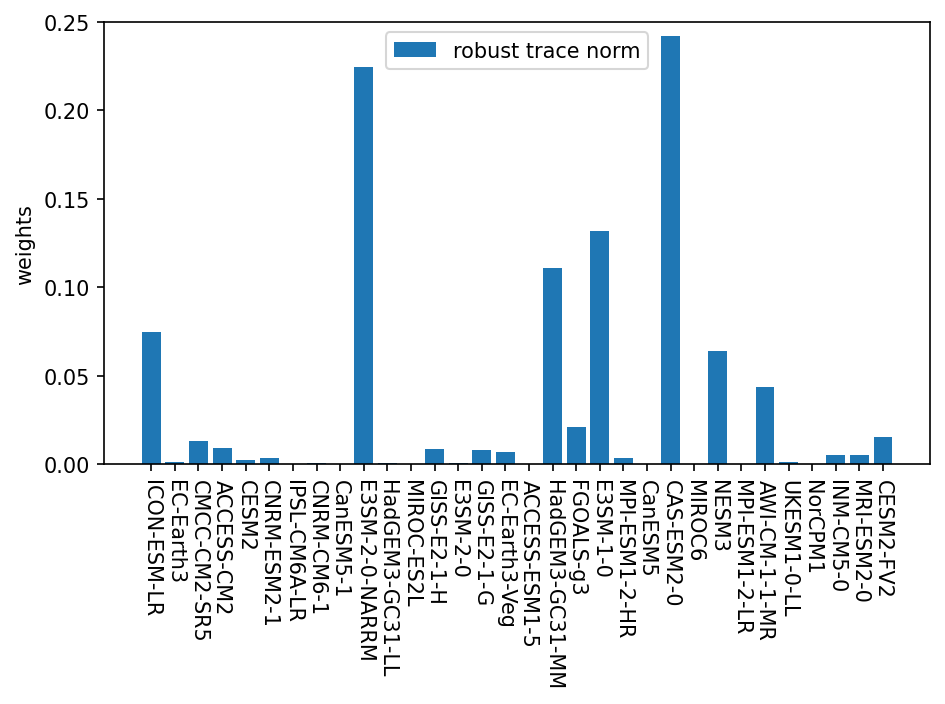

In [70]:
weights_robust = compute_weights(training_models,w_robust,x_rescaled,y_rescaled,notnan_idx,mu_=mu_tmp)
weights_trace_norm = compute_weights(training_models,w_robust_trace,x_rescaled,y_rescaled,notnan_idx,mu_=mu_tmp)
# # weights_robust_lr = compute_weights(training_models,w_robust_lr,x_rescaled,y_rescaled,notnan_idx,mu_=mu_tmp)

# # plot the weights
plt.close('all')
################# plot the rmse #################
fig, ax = plt.subplots()

# plot robust weights
ax.bar(training_models, list(weights_robust.values()),label=r'robust weight model')
ax.set_ylabel('weights')
ax.set_ylim(0.0,0.25)
ax.legend()
ax.set_xticklabels(training_models, rotation=-90)

plt.tight_layout()
plt.savefig("results/robust_weights_"+str(mu_tmp)+"_"+str(lambda_tmp)+".eps", dpi=150)
plt.show()

fig, ax = plt.subplots()

# plot robust weights trace norm
ax.bar(training_models, list(weights_trace_norm.values()),label=r'robust trace norm')
ax.set_ylabel('weights')
ax.set_ylim(0.0,0.25)
ax.legend()
ax.set_xticklabels(training_models, rotation=-90)

# plot robust weights low rank
# plt.add_subplot(fig, ax, 1, training_models, weights_robust, 'Robust low-rank', 'b')
# ax.bar(training_models, list(weights_robust_lr.values()),label=r'robust weights (rank $\leq {}$)'.format(r))
# # ax.set_ylabel('weights')
# # ax.legend()
# # ax.set_xticklabels(training_models, rotation=-90)

plt.tight_layout()
plt.savefig("results/robust_trace_weights_"+str(mu_tmp)+"_"+str(lambda_tmp)+".eps", dpi=150)
plt.show()

In [59]:
# compute predictions
# build test set
x_test_tmp = x_rescaled[m0]
y_test_tmp = y_rescaled[m0]


# ridge
y_pred_ridge = prediction(x_test_tmp, w_ridge,notnan_idx, nan_idx)

# low rank ridge
y_pred_ridge_lr = prediction(x_test_tmp, w_ridge_lr,notnan_idx, nan_idx)

# robust
y_pred_robust = prediction(x_test_tmp, w_robust,notnan_idx, nan_idx)

# # # # robust low rank ridge regression
y_pred_robust_lr= prediction(x_test_tmp, w_robust_lr,notnan_idx, nan_idx)

# # trace norm
y_pred_trace = prediction(x_test_tmp, w_trace,notnan_idx, nan_idx)

# # # robust trace norm
y_pred_robust_trace = prediction(x_test_tmp, w_robust_trace,notnan_idx, nan_idx)


In [60]:
# print the rmse for each method
print('Ridge regression: ', torch.nanmean((y_test_tmp-y_pred_ridge)**2).item() )
print('Low rank ridge regression: ', torch.nanmean((y_test_tmp-y_pred_ridge_lr)**2).item() )
print('Robust regression: ', torch.nanmean((y_test_tmp-y_pred_robust)**2).item() )
print('Robust regression (low rank): ', torch.nanmean((y_test_tmp-y_pred_robust_lr)**2).item() )
print('Trace norm: ', torch.nanmean((y_test_tmp-y_pred_trace)**2).item() )
print('Robust trace norm: ', torch.nanmean((y_test_tmp-y_pred_robust_trace)**2).item() )

Ridge regression:  3.689941167831421
Low rank ridge regression:  3.6742103099823
Robust regression:  2.5070223808288574
Robust regression (low rank):  2.6203713417053223
Trace norm:  2.8064794540405273
Robust trace norm:  2.4594736099243164


In [76]:
from matplotlib import animation

time_period=34
fmax = 2.0
fmin = -3.0


plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()


plt.close('all')
fig0 = plt.figure(figsize=(24,16))

ax0 = fig0.add_subplot(3, 3, 1)        
ax0.set_title(r'Groundtruth', size=7,pad=3.0)
ax0.set_xlabel(r'x', size=7)
ax0.set_ylabel(r'y', size=7)

ax1 = fig0.add_subplot(3, 3, 2)        
ax1.set_title(r'Ridge regression', size=7,pad=3.0)
ax1.set_xlabel(r'x', size=7)
ax1.set_ylabel(r'y', size=7)

ax2 = fig0.add_subplot(3, 3, 3)        
ax2.set_title(r'Low rank ridge regression', size=7,pad=3.0)
ax2.set_xlabel(r'x', size=7)
ax2.set_ylabel(r'y', size=7)

ax3 = fig0.add_subplot(3, 3, 5)        
ax3.set_title(r'Robust regression', size=7,pad=3.0)
ax3.set_xlabel(r'x', size=7)
ax3.set_ylabel(r'y', size=7)

ax4 = fig0.add_subplot(3, 3, 6)        
ax4.set_title(r'Low rank Robust regression', size=7,pad=3.0)
ax4.set_xlabel(r'x', size=7)
ax4.set_ylabel(r'y', size=7)

ax5 = fig0.add_subplot(3, 3, 8)
ax5.set_title(r'Trace norm', size=7,pad=3.0)
ax5.set_xlabel(r'x', size=7)
ax5.set_ylabel(r'y', size=7)

ax6 = fig0.add_subplot(3, 3, 9)
ax6.set_title(r'Robust trace norm', size=7,pad=3.0)
ax6.set_xlabel(r'x', size=7)
ax6.set_ylabel(r'y', size=7)

# get first run of the test set
idx_run = 0
y_to_plot_target = y_test_tmp[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size)
y_to_plot_pred_ridge = y_pred_ridge[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # ridge
y_to_plot_pred_ridge_lr = y_pred_ridge_lr[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # ridge low rank
y_to_plot_pred_robust = y_pred_robust[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # robust 
y_to_plot_pred_robust_lr = y_pred_robust_lr[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # robust low rank
y_to_plot_pred_trace = y_pred_trace[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # trace norm
y_to_plot_pred_robust_trace = y_pred_robust_trace[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # robust trace norm

im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=fmin,vmax=fmax)
im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=fmin,vmax=fmax)
im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge_lr,vmin=fmin,vmax=fmax)
im3 = ax3.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=fmin,vmax=fmax)
im4 = ax4.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust_lr,vmin=fmin,vmax=fmax)
im5 = ax5.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_trace,vmin=fmin,vmax=fmax)
im6 = ax6.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust_trace,vmin=fmin,vmax=fmax)

def animate_maps(i):

    y_to_plot_target = y_test_tmp[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size)
    y_to_plot_pred_ridge = y_pred_ridge[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # ridge
    y_to_plot_pred_ridge_lr = y_pred_ridge_lr[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # ridge low rank
    y_to_plot_pred_robust = y_pred_robust[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # robust 
    y_to_plot_pred_robust_lr = y_pred_robust_lr[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # robust low rank
    y_to_plot_pred_trace = y_pred_trace[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # trace norm
    y_to_plot_pred_robust_trace = y_pred_robust_trace[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # robust trace norm


    im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=fmin,vmax=fmax)
    im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=fmin,vmax=fmax)
    im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge_lr,vmin=fmin,vmax=fmax)
    im3 = ax3.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=fmin,vmax=fmax)
    im4 = ax4.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust_lr,vmin=fmin,vmax=fmax)
    im5 = ax5.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_trace,vmin=fmin,vmax=fmax)
    im6 = ax6.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust_trace,vmin=fmin,vmax=fmax)
    
plt.colorbar(im0, ax=ax0, shrink=0.3)
plt.colorbar(im1, ax=ax1, shrink=0.3)
plt.colorbar(im2, ax=ax2, shrink=0.3)
plt.colorbar(im3, ax=ax3, shrink=0.3)
plt.colorbar(im4, ax=ax4, shrink=0.3)
plt.colorbar(im5, ax=ax5, shrink=0.3)
plt.colorbar(im6, ax=ax6, shrink=0.3)
animation.FuncAnimation(fig0, animate_maps, frames=time_period)

In [ ]:
# from matplotlib import animation

# time_period=34
# fmax = 5.0
# fmin = -1.0


# plt.rcParams["animation.html"] = "jshtml"
# plt.rcParams['figure.dpi'] = 150  
# plt.ioff()


# plt.close('all')
# fig0 = plt.figure(figsize=(24,16))

# ax0 = fig0.add_subplot(1, 3, 1)        
# ax0.set_title(r'Groundtruth', size=7,pad=3.0)
# ax0.set_xlabel(r'x', size=7)
# ax0.set_ylabel(r'y', size=7)

# ax1 = fig0.add_subplot(1, 3, 2)        
# ax1.set_title(r'Ridge regression', size=7,pad=3.0)
# ax1.set_xlabel(r'x', size=7)
# ax1.set_ylabel(r'y', size=7)

# ax2 = fig0.add_subplot(1, 3, 3)        
# ax2.set_title(r'Robust regression', size=7,pad=3.0)
# ax2.set_xlabel(r'x', size=7)
# ax2.set_ylabel(r'y', size=7)



# # get first run of the test set
# idx_run = 0
# y_to_plot_target = y_test_tmp[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size)
# y_to_plot_pred_ridge = y_pred_ridge[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # ridge
# y_to_plot_pred_ridge_lr = y_pred_ridge_lr[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # ridge low rank
# y_to_plot_pred_robust = y_pred_robust[idx_run,0,:].detach().numpy().reshape(lat_size,lon_size) # robust


# im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=fmin,vmax=fmax)
# im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=fmin,vmax=fmax)
# im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=fmin,vmax=fmax)



# def animate_maps(i):

#     y_to_plot_target = y_test_tmp[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size)
#     y_to_plot_pred_ridge = y_pred_ridge[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # ridge
#     y_to_plot_pred_robust = y_pred_robust[idx_run,i,:].detach().numpy().reshape(lat_size,lon_size) # ridge low rank

#     im0 = ax0.pcolormesh(lon_grid,lat_grid,y_to_plot_target,vmin=fmin,vmax=fmax)
#     im1 = ax1.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_ridge,vmin=fmin,vmax=fmax)
#     im2 = ax2.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=fmin,vmax=fmax)
#     # im3 = ax3.pcolormesh(lon_grid,lat_grid,y_to_plot_pred_robust,vmin=fmin,vmax=fmax)
    
# plt.colorbar(im0, ax=ax0, shrink=0.3)
# plt.colorbar(im1, ax=ax1, shrink=0.3)
# plt.colorbar(im2, ax=ax2, shrink=0.3)
# # animation.FuncAnimation(fig0, animate_maps, frames=time_period)
# anim_tmp = animation.FuncAnimation(fig0, animate_maps, frames=time_period)
# anim_tmp.save('results/animation_'+m0+'.mp4', writer="ffmpeg", fps=2)

In [39]:
lambda_tmp = 500.0
mu_tmp = 1000.0
nu_tmp = 1000.0
r = 5

# compute the rmse for the ridge regression
w_ridge, rmse_mean_ridge, weights_ridge, training_loss_ridge = leave_one_out_procedure(x,y,means,vars,\
                                        lon_size,lat_size, notnan_idx, nan_idx,time_period=34,\
                                        method='ridge',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,nu_=nu_tmp,\
                                        lr=1e-5,nb_gradient_iterations=20,dtype=torch.float32,verbose=True)

# # same for the trace norm
w_ridge_lr, rmse_mean_ridge_lr, weights_ridge_lr, training_loss_ridge_lr = leave_one_out_procedure(x,y,means,vars,\
                                        lon_size,lat_size, notnan_idx, nan_idx,time_period=34,\
                                        method='ridge',rank=r,lambda_=lambda_tmp,mu_=mu_tmp,nu_=nu_tmp,\
                                        lr=1e-5,nb_gradient_iterations=20,dtype=torch.float32,verbose=False)


# # same for the trace norm
# w_trace, rmse_mean_trace, weights_trace, training_loss_trace = leave_one_out_procedure(x,y,means,vars,\
#                                         lon_size,lat_size, notnan_idx, nan_idx,time_period=34,\
#                                         method='trace_norm',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,nu_=nu_tmp,\
#                                         lr=1e-5,nb_gradient_iterations=100,dtype=torch.float32,verbose=True)

# # same for the robust model 
# w_robust, rmse_mean_robust, weights_robust, training_loss_robust = \
#                                         leave_one_out_procedure(x,y,means,vars,\
#                                         lon_size,lat_size, notnan_idx, nan_idx,time_period=34,\
#                                         method='robust',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,nu_=nu_tmp,\
#                                         lr=1e-6,nb_gradient_iterations=100,dtype=torch.float32,verbose=False)


# same for the robust trace norm model 
# w_robust_trace, rmse_mean_robust_trace, weights_robust_trace, training_loss_robust_trace = \
#                                         leave_one_out_procedure(x,y,means,vars,\
#                                         lon_size,lat_size, notnan_idx, nan_idx,time_period=34,\
#                                         method='robust_trace_norm',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,nu_=nu_tmp,\
#                                         lr=1e-6,nb_gradient_iterations=100,dtype=torch.float32,verbose=False)

Loss function:  1740426.0
RMSE (mean) on model  ICON-ESM-LR  :  2.610307216644287
Loss function:  1713399.0
RMSE (mean) on model  EC-Earth3  :  1.7651662826538086
Loss function:  1717623.5
RMSE (mean) on model  CMCC-CM2-SR5  :  1.4071661233901978
Loss function:  1728330.5
RMSE (mean) on model  ACCESS-CM2  :  0.15265092253684998
Loss function:  1730982.25
RMSE (mean) on model  CESM2  :  0.8377770781517029
Loss function:  1730505.625
RMSE (mean) on model  CNRM-ESM2-1  :  0.21594984829425812
Loss function:  1702898.0
RMSE (mean) on model  IPSL-CM6A-LR  :  0.09021738916635513
Loss function:  1707483.875
RMSE (mean) on model  CNRM-CM6-1  :  0.21011392772197723
Loss function:  1675373.625
RMSE (mean) on model  CanESM5-1  :  0.26374441385269165
Loss function:  1741323.375
RMSE (mean) on model  E3SM-2-0-NARRM  :  0.28666290640830994
Loss function:  1681476.375
RMSE (mean) on model  HadGEM3-GC31-LL  :  0.10587162524461746
Loss function:  1719389.5
RMSE (mean) on model  MIROC-ES2L  :  0.40908122

In [40]:
################### Ridge regresssion ########################
# compute the ridge loo
rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo 
# Ridge
worst_loo_ridge = np.max(rmse_ridge_tmp)
mean_loo_ridge = np.mean(rmse_ridge_tmp)


# quantile 95, 90, 75
q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)

################### Ridge low rank regresssion ########################
# compute the ridge loo
rmse_ridge_lr_tmp =  np.array(list(rmse_mean_ridge_lr.values()))

# worst loo
worst_loo_ridge_lr = np.max(rmse_ridge_lr_tmp)
mean_loo_ridge_lr = np.mean(rmse_ridge_lr_tmp)

# quantile 95, 90, 75
q_loo_95_ridge_lr = np.quantile(rmse_ridge_lr_tmp, 0.95)
q_loo_90_ridge_lr = np.quantile(rmse_ridge_lr_tmp, 0.90)
q_loo_75_ridge_lr = np.quantile(rmse_ridge_lr_tmp, 0.75)
q_loo_50_ridge_lr = np.quantile(rmse_ridge_lr_tmp, 0.5)

################### Trace norm ########################
# compute the ridge loo
rmse_trace_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo
worst_loo_trace = np.max(rmse_trace_tmp)
mean_loo_trace = np.mean(rmse_trace_tmp)

# quantile 95, 90, 75
q_loo_95_trace = np.quantile(rmse_trace_tmp, 0.95)
q_loo_90_trace = np.quantile(rmse_trace_tmp, 0.90)
q_loo_75_trace = np.quantile(rmse_trace_tmp, 0.75)
q_loo_50_trace = np.quantile(rmse_trace_tmp, 0.5)

################### Robust weight approach ########################
# compute the ridge loo
rmse_robust_tmp =  np.array(list(rmse_mean_ridge.values()))

# worst loo
worst_loo_robust = np.max(rmse_robust_tmp)
mean_loo_robust = np.mean(rmse_robust_tmp)

# quantile 95, 90, 75
q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

# print all the results
print("======= Statistics ========")
print("\n")
print("          Ridge   RR-Lr   Rob. trace  Rob. weight ")
print("Worst:    {:.3f}   {:.3f}   {:.3f}    {:.3f}".format(worst_loo_ridge,worst_loo_ridge_lr,worst_loo_trace, worst_loo_robust))
print("0.95:     {:.3f}   {:.3f}   {:.3f}    {:.3f}".format(q_loo_95_ridge,q_loo_95_ridge_lr,q_loo_95_trace, q_loo_95_robust))
print("0.90:     {:.3f}   {:.3f}   {:.3f}    {:.3f}".format(q_loo_90_ridge,q_loo_90_ridge_lr,q_loo_90_trace, q_loo_90_robust))
print("0.75:     {:.3f}   {:.3f}   {:.3f}    {:.3f}".format(q_loo_75_ridge,q_loo_75_ridge_lr,q_loo_75_trace, q_loo_75_robust))
print("Median:   {:.3f}   {:.3f}   {:.3f}    {:.3f}".format(q_loo_50_ridge,q_loo_50_ridge_lr,q_loo_50_trace, q_loo_50_robust))
print("Mean:     {:.3f}   {:.3f}   {:.3f}    {:.3f}".format(mean_loo_ridge,mean_loo_ridge_lr,mean_loo_trace, mean_loo_robust))



======= Statistics ========


          Ridge   RR-Lr   Rob. trace  Rob. weight 
Worst:    3.690   3.674   3.690    3.690
0.95:     2.896   2.866   2.896    2.896
0.90:     1.866   1.841   1.866    1.866
0.75:     0.933   0.914   0.933    0.933
Median:   0.340   0.308   0.340    0.340
Mean:     0.816   0.792   0.816    0.816


## PCA of matrix W to observe the low-rank subspace

In [63]:
# compute PCA low rank decomposition of w_robust_lr with pytorch
U, S, V = torch.pca_lowrank(w_robust_trace, q=10)

# compute projection of w_robust_lr onto low rank coordinate 
w_proj = w_robust_trace @ V
w_proj[nan_idx,:] = float('nan')

V[nan_idx,:] = float('nan') # set nan values to nan

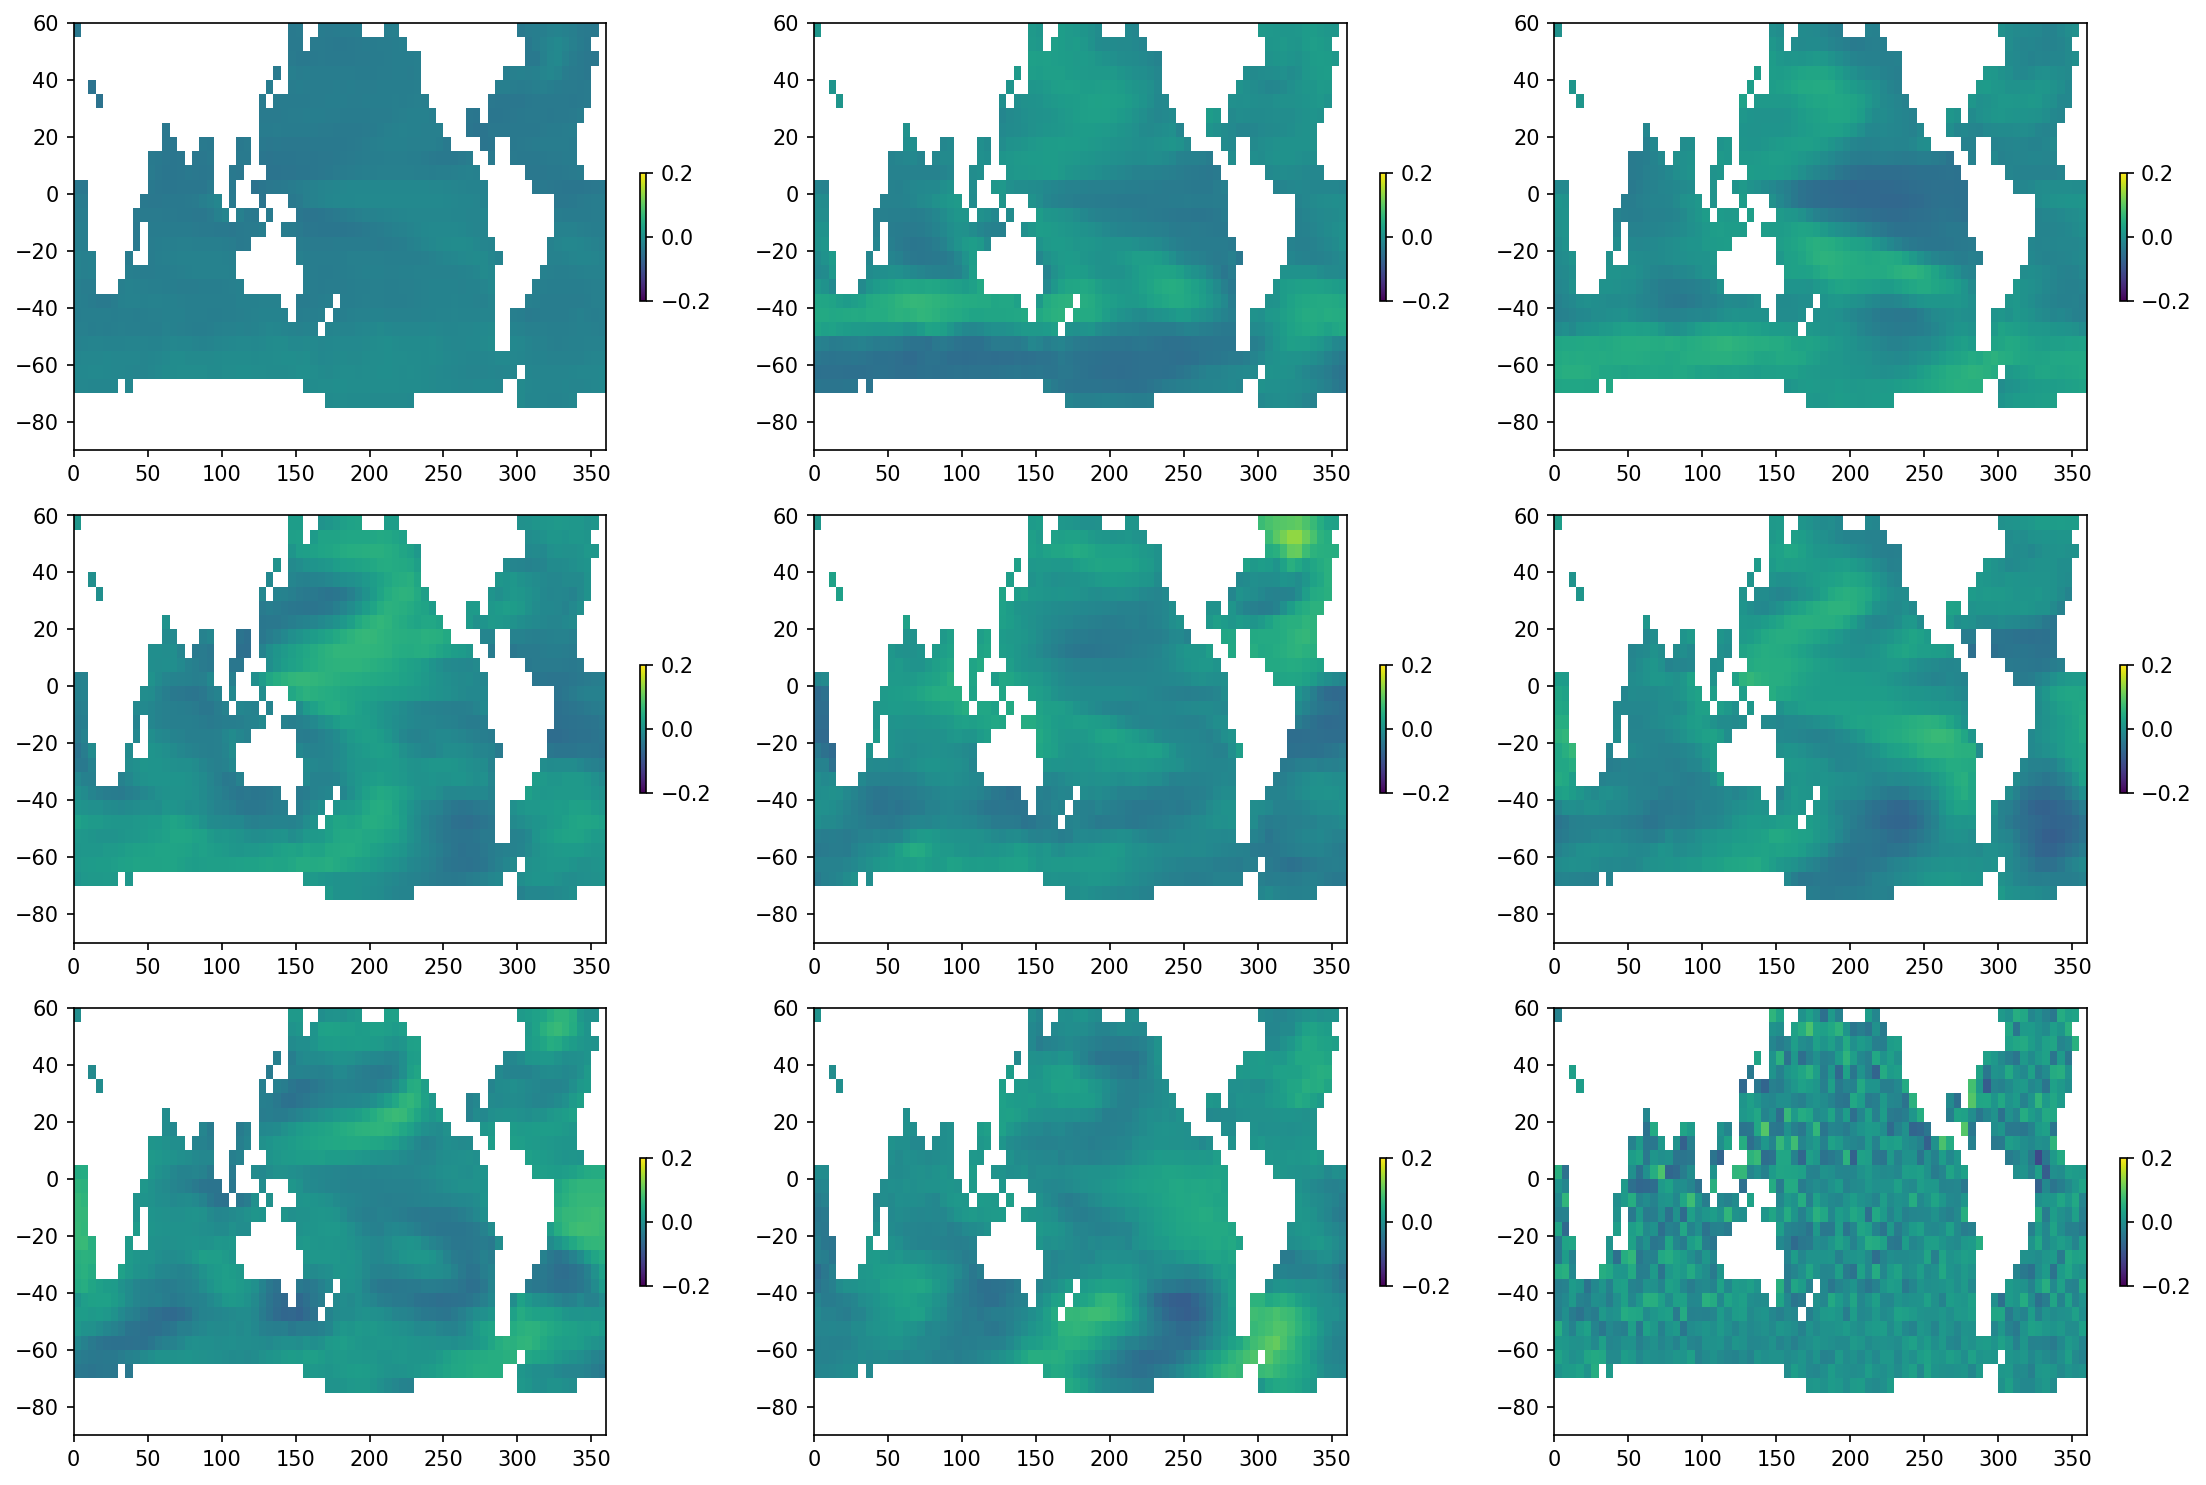

In [64]:
# # display 9 first projected components as grid maps 

plt.close('all')
fig, ax = plt.subplots(3, 3, figsize=(15, 10))
vmin = -0.2
vmax = 0.2
for i in range(9):
    ax_i = ax[i // 3, i % 3]
    im = ax_i.pcolormesh(lon_grid, lat_grid, V[:, i].detach().numpy().reshape(lat_size, lon_size), vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=ax_i, shrink=0.3)
plt.tight_layout()
plt.show()


# Compute linear trend per grid cell

In [ ]:
# # Sample time series data (y values)
# y_tmp = y_train.T
# print(y_tmp.shape)

# # Time indices
# t = torch.arange(len(y), dtype=torch.float32).unsqueeze(1)  # Reshape for linear regression

# # Add bias term (column of ones for intercept)
# X = torch.cat([t, torch.ones_like(t)], dim=1)  # Shape: (n,2), where first column is t, second is bias

# # Solve for linear regression coefficients: (X^T X)^(-1) X^T y
# theta = torch.linalg.lstsq(X, y).solution  # Least squares solution

# # Extract slope and intercept
# slope, intercept = theta[0].item(), theta[1].item()

# # Compute fitted trend
# trend = X @ theta

# # Print results
# print(f"Slope (b): {slope}")
# print(f"Intercept (a): {intercept}")
# print(f"Fitted Trend: {trend.numpy()}")

In [ ]:
# w_robust, y_pred, y_test, rmse_train = leave_one_out_single(m0,x,y,vars,\
#                                          lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                          method='robust',rank=None,lambda_=100.0,mu_=1000.0,\
#                                          lr=1e-5,nb_gradient_iterations=5,verbose=True)

In [ ]:
# lambda_tmp = 100.0
# mu_tmp = 1000.0
# rank_tmp = 10

# W_ridge, rmse_mean_ridge, weights_ridge = leave_one_out_procedure(x,y,vars,\
#                                                                 lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                 method='ridge',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                 lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

In [ ]:
# W_rrr, rmse_mean_rrr, training_loss_rrr, weights_rrr = leave_one_out_procedure(x,y,vars,\
#                                                                             lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                             method='rrr',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                             lr=1e-5,nb_gradient_iterations=50,verbose=True,dtype=dtype)

In [ ]:
# W_robust, rmse_mean_robust, weights_robust = leave_one_out_procedure(x,y,vars,\
#                                                                     lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                     method='robust',rank=None,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                     lr=1e-5,nb_gradient_iterations=100,verbose=True)

In [ ]:
# W_robust_rrr, rmse_mean_robust_rrr, weights_robust_rrr = leave_one_out_procedure(x,y,vars,\
#                                                                                     lon_size,lat_size, notnan_idx,nan_idx,time_period=33,\
#                                                                                     method='robust',rank=10,lambda_=lambda_tmp,mu_=mu_tmp,\
#                                                                                     lr=1e-5,nb_gradient_iterations=100,verbose=True)

In [ ]:
# ################### Ridge regresssion ########################
# # compute the ridge loo
# rmse_ridge_tmp =  np.array(list(rmse_mean_ridge.values()))

# # worst loo Ridge
# worst_loo_ridge = np.max(rmse_ridge_tmp)
# mean_loo_ridge = np.mean(rmse_ridge_tmp)


# # quantile 95, 90, 75
# q_loo_95_ridge = np.quantile(rmse_ridge_tmp, 0.95)
# q_loo_90_ridge = np.quantile(rmse_ridge_tmp, 0.90)
# q_loo_75_ridge = np.quantile(rmse_ridge_tmp, 0.75)
# q_loo_50_ridge = np.quantile(rmse_ridge_tmp, 0.5)


# ######################## compute the ridge rrr ######################
# rmse_rrr_tmp =  np.array(list(rmse_mean_rrr.values()))

# # worst loo Ridge
# worst_loo_rrr = np.max(rmse_rrr_tmp)
# mean_loo_rrr = np.mean(rmse_rrr_tmp)


# # quantile 95, 90, 75
# q_loo_95_rrr = np.quantile(rmse_rrr_tmp, 0.95)
# q_loo_90_rrr = np.quantile(rmse_rrr_tmp, 0.90)
# q_loo_75_rrr = np.quantile(rmse_rrr_tmp, 0.75)
# q_loo_50_rrr = np.quantile(rmse_rrr_tmp, 0.5)


# ######################## compute the robust regression ######################
# rmse_robust_tmp =  np.array(list(rmse_mean_robust.values()))

# # worst loo Ridge
# worst_loo_robust = np.max(rmse_robust_tmp)
# mean_loo_robust = np.mean(rmse_robust_tmp)


# # quantile 95, 90, 75
# q_loo_95_robust = np.quantile(rmse_robust_tmp, 0.95)
# q_loo_90_robust = np.quantile(rmse_robust_tmp, 0.90)
# q_loo_75_robust = np.quantile(rmse_robust_tmp, 0.75)
# q_loo_50_robust = np.quantile(rmse_robust_tmp, 0.5)

# ######################## compute the robust regression with low rank constraint ######################
# rmse_robust_rrr =  np.array(list(rmse_mean_robust_rrr.values()))

# # worst loo Ridge
# worst_loo_robust_rrr = np.max(rmse_robust_rrr)
# mean_loo_robust_rrr = np.mean(rmse_robust_rrr)


# # quantile 95, 90, 75
# q_loo_95_robust_rrr = np.quantile(rmse_robust_rrr, 0.95)
# q_loo_90_robust_rrr = np.quantile(rmse_robust_rrr, 0.90)
# q_loo_75_robust_rrr = np.quantile(rmse_robust_rrr, 0.75)
# q_loo_50_robust_rrr = np.quantile(rmse_robust_rrr, 0.5)


# print("======= Statistics ========")
# print("\n")
# print("          Ridge   RR-Lr   Robust  Robust-Lr")
# print("Worst:    {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(worst_loo_ridge,worst_loo_rrr,worst_loo_robust, worst_loo_robust_rrr))
# print("0.95:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_95_ridge,q_loo_95_rrr,q_loo_95_robust, q_loo_95_robust_rrr))
# print("0.90:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_90_ridge,q_loo_90_rrr,q_loo_90_robust, q_loo_90_robust_rrr))
# print("0.75:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_75_ridge,q_loo_75_rrr,q_loo_75_robust, q_loo_75_robust_rrr))
# print("Median:   {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(q_loo_50_ridge,q_loo_50_rrr,q_loo_50_robust, q_loo_50_robust_rrr))
# print("Mean:     {:.3f}   {:.3f}   {:.3f}   {:.3f}".format(mean_loo_ridge,mean_loo_rrr,mean_loo_robust, mean_loo_robust_rrr))

In [ ]:
# w, rmse, training_loss, weights = cross_validation_procedure(x,y,vars,\
#                                                            lon_size,lat_size,notnan_idx,nan_idx,time_period=33,\
#                                                            method='robust', rank=None, lambda_range=torch.tensor([100.0]), mu_range=torch.tensor([1000.0]),\
#                                                            lr=1e-5,nb_gradient_iterations=100,verbose=True)